## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, the goal is to work through the collected data to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability



In [1]:
#import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df['converted']==1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group=="treatment"')['landing_page'].value_counts()[1]+df.query('group=="control"')['landing_page'].value_counts()[1]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, We cannot be sure if this row truly received the new or old page, so we are gonna remove these rows.

In [8]:
#remove the rows and store it in df2
df2=df.drop(df.query('group=="treatment"').query('landing_page=="old_page"').index)
df2=df2.drop(df.query('group=="control"').query('landing_page=="new_page"').index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to wrangle data furtherly.

a. How many unique **user_id**s are in **df2?**

In [10]:
df2['user_id'].nunique()

290584

b.the row information of repeated 'user_id'

In [11]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [12]:
df2 = df2.drop([1899])

In [13]:
print(sum(df2['user_id'].duplicated()))
df2[df2.duplicated(['user_id'], keep=False)]

0


,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to explore the converted rate for different groups.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
(df2['converted']==1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
(df2.query('group=="control"')['converted']==1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
(df2.query('group=="treatment"')['converted']==1).mean()

0.11880806551510564

In [17]:
#the observed converted rate difference between "treatment group" and "control group"
obs_diff=(df2.query('group=="treatment"')['converted']==1).mean()-(df2.query('group=="control"')['converted']==1).mean()
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page']=='new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The results from parts(a) through (d) above show that the convertion rate for 'treatment group' is less than that for 'control group'. So, there is no sufficient evidence to conclude that the new treatment leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` **Null and Alternative hypothesis** 

Null hypotheses:convertion rate for new page is equal to or less than the convertion rate for old page

Alternative hypothesis:convertion rate for new page is larger than the convertion rate for old page

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new=(df2['converted']==1).mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old=(df2['converted']==1).mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new=df2.query('group=="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old=df2.query('group=="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [33]:
new_page_converted=np.random.binomial(n_new,p_new)/n_new 
#new_page_converted
#new_page_converted=np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
new_page_converted

0.12009496937581722

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted=np.random.binomial(n_old,p_old)/n_old
old_page_converted

0.12078555006401696

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted-old_page_converted

-0.0029478238235655096

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs

array([  2.01431452e-03,  -1.77786347e-03,   8.71871290e-04, ...,
         1.24372252e-03,   3.76506798e-04,   8.04683522e-05])

i. Plot a histogram of the **p_diffs**.  

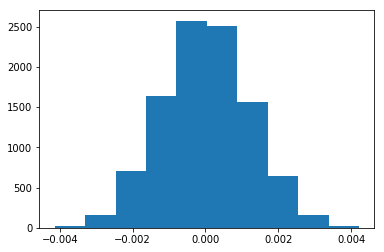

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
pval=len(p_diffs[p_diffs > obs_diff])/len(p_diffs)
print(pval)

0.9049


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** In part j, I have computed the p-value, which is the evidence against a null hypothesis. The smaller the p-value, the stronger the evidence that we should reject the null hypothesis. However, the p-value here is 0.90, which is very large, indicating there is an 90% chance that the observed result could be random. So, there is no strong evidence suggesting that there is a difference between the respective conversion rates for the new and old pages. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old =(df2.query('landing_page=="old_page"')['converted']==1).sum()
convert_new =(df2.query('landing_page=="new_page"')['converted']==1).sum() 
n_old =df2.query('landing_page=="old_page"').shape[0]
n_new =df2.query('landing_page=="new_page"').shape[0]

print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489
17264
145274
145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
from statsmodels.stats.proportion import proportions_ztest
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(pval)
print(z_score)

0.9049
-1.31092419842


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer** The z-score is -1.31, which is between -1.96 and 1.96, and the p-value is 0.90, which is larger than 0.05. Given these values, we can not reject our null hypothesis. They agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept']=1
df2[['ab_page','old_page']]=pd.get_dummies(df2['landing_page'])
df2=df2.drop(columns=['old_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
import statsmodels.api as sm
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 25 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        06:10:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:** The p-value assocaited with ab_page is 0.190, which differs the p-value found in part II. The p-value differs from the value found in Part II, because the null and alternative hypotheses are different. The null hypothesis in this logistic regression experiment is that there is no relationship between the page and conversion rate of users.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** Since novelty effect and change aversion affect existing users when they first experience a change, duration is a factor which should be considered into the regression model. However, adding time duration into the regression model might cause inaccurate results, since the old page, new page and time duration are not fully independent factors.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [34]:
df_country=pd.read_csv('countries.csv')
print(df_country.head())
print(df_country.info())

   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None


In [35]:
df_combined=pd.merge(df2,df_country,on='user_id')
df_combined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [36]:
#check clomumn['country'] value_counts
df_combined['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [37]:
df_combined[['US','UK','CA']]=pd.get_dummies(df_combined['country'])
df_combined=df_combined.drop('US',axis=1)
df_combined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [38]:
lm_country=sm.Logit(df_combined['converted'],df_combined[['intercept','UK','CA']])
result2=lm_country.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 25 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        06:11:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
CA             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [39]:
np.exp(0.0507),np.exp(0.0408)

(1.0520072437650141, 1.0416437559600236)

**Conclusion:** Convertion rate is 1.05 times as likely in UK and 1.04 times likely in CA compared to US, holding all else constant. Since all p-values are greater than 0.05, so these variables are not sufficiently statistically significant to let us reject the null hypothesis.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
df_combined['ab_UK'] = df_combined['ab_page'] * df_combined['UK']
df_combined['ab_CA'] = df_combined['ab_page'] * df_combined['CA']

logit_mod = sm.Logit(df_combined['converted'], df_combined[['intercept','ab_page','ab_UK', 'ab_CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 25 Jul 2020   Pseudo R-squ.:               3.351e-05
Time:                        06:11:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0827      0.038     -2.176      0.030      -0.157      -0.008
ab_UK          0.0901      0.040      2.225      0.026       0.011       0.169
ab_CA          0.0644      0.038      1.679      0.093      -0.011       0.140
==============================================================================
"""

In [41]:
#check VIFs
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
y,x=dmatrices('converted ~ ab_page + ab_UK + ab_CA', df_combined, return_type = 'dataframe')
vif=pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif

,VIF Factor,features
0,2.000248,Intercept
1,10.450206,ab_page
2,5.206621,ab_UK
3,9.712089,ab_CA


**Conclusion:** The p-value of ab_page is 0.03, which is smaller than 0.05. However, this p-value cannot be considered as sufficient evidence to reject the null hypothesis because of multi-collinearity. As we can see, the vif for ab_page is 10.45, which is larger than 10, indicating that page is highly correlated with country. 

**Suggestions:** Throughout the tests of probability, A/B test and regression, even though we arrived at varying p-values, the same result was attained: We fail to reject the null hypothesis. This means we do not have any significant evidence to show that the new page is performing better than old page in terms of conversion. I think the duration of this experiment should be increased, with data points from the first 7 days excluded, in order to reduce the effects of user habits, namely change aversion and novelty effect.

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0